In [2]:
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import os
import json
from konlpy.tag import Okt
import pymysql.cursors
import pandas as pd
import re

In [3]:
conn = pymysql.connect(host='localhost',
                       user='lyunj',
                       password='Dldbswo77@',
                       db='coupang_review',  # coupang_review 스키마 생성 필요
                       charset='utf8',
                       cursorclass=pymysql.cursors.DictCursor)
try:
    with conn.cursor() as curs:
        sql = 'select *,(pow(special_char_count,2) + pow(manufacturer_count,2) + pow(product_count,2)) as c1 from review_analyzing_data'
        curs.execute(sql)
        result = curs.fetchall()
        df = pd.DataFrame(result)
finally:
    conn.close()

In [4]:
okt = Okt()

In [5]:
def tokenize(review):
    return ['/'.join(t) for t in okt.pos(review, norm=True, stem=True)]

In [6]:
import nltk

with open('./review_token.json', encoding='utf-8') as f:
    review_token = json.load(f)

tokens = [t for d in review_token for t in d[0] if ((
    t.split('/')[1] == 'Noun') or (t.split('/')[1] == 'Adjective'))]

text = nltk.Text(tokens, name='NMSC')

print(len(set(text.tokens)))

35951


In [7]:
tokens_1 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '1')]

text_1 = nltk.Text(tokens_1, name='NMSC')

rating_1 = text_1.vocab().most_common(1000)

tokens_5 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '5')]
text_5 = nltk.Text(tokens_5, name='NMSC')

rating_5 = text_5.vocab().most_common(1000)

rating_1_word = [x[0] for x in rating_1]
rating_5_word = [x[0] for x in rating_5]

common_word = [x for x in rating_1_word if x in rating_5_word]

rating_1_word_not_common = [x for x in rating_1_word if x not in common_word]
rating_5_word_not_common = [x for x in rating_5_word if x not in common_word]

# tokens_1_word = [x for x in tokens_1 if x not in common_word]
# tokens_5_word = [x for x in tokens_5 if x not in common_word]

In [8]:
rating_1_count = []
for word,count in rating_1:
    if word in common_word:
        rating_1_count.append(count)
print(len(rating_1_count))

698


In [9]:
rating_5_count = []
for word,count in rating_5:
    if word in common_word:
        rating_5_count.append(count)
print(len(rating_5_count))

698


In [10]:
r = 19050/56990
rating_5_count = list(map(lambda x : x*r,rating_5_count))

In [11]:
r = 102.1/155.3
rating_5_count = list(map(lambda x : x*r,rating_5_count))

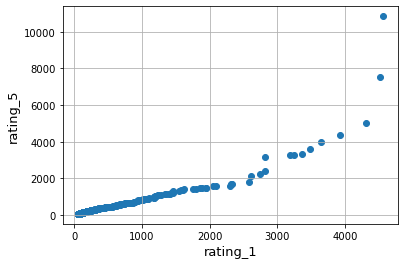

In [13]:
# 1점 리뷰에서 많이 쓰는 단어는 5점 리뷰에서도 많이 쓴다
plt.scatter(rating_1_count,rating_5_count)
plt.xlabel("rating_1", fontsize=13)
plt.ylabel("rating_5", fontsize=13)
plt.grid()
plt.show()

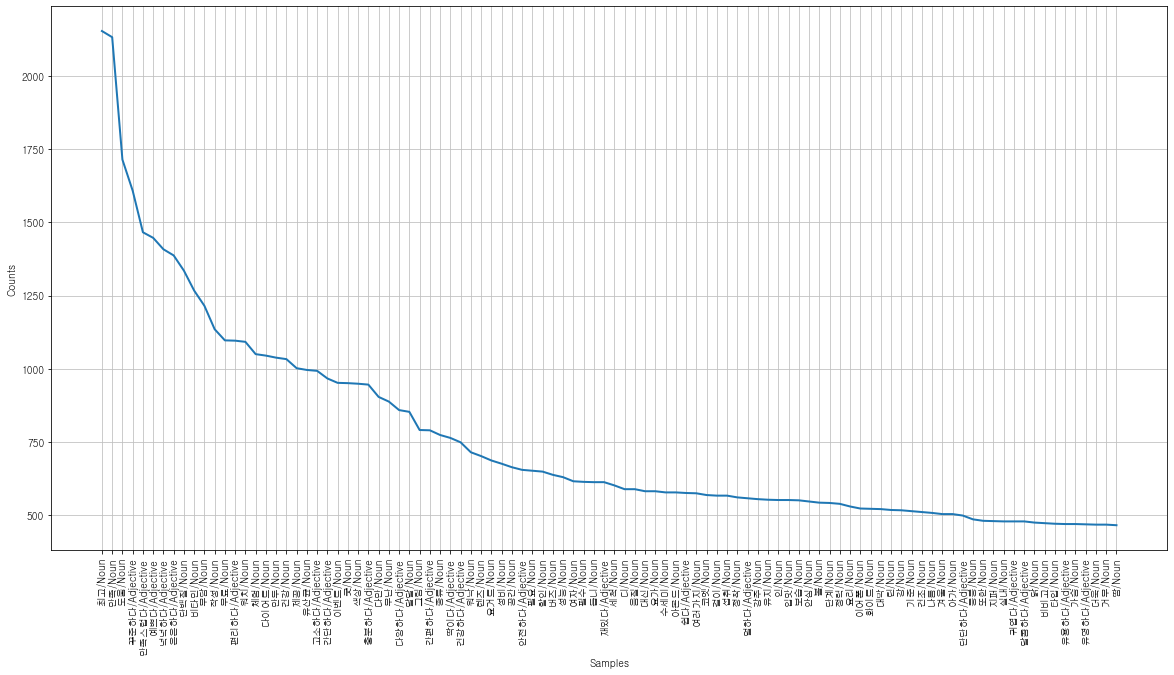

In [14]:
temp = [x for x in tokens_5 if x in rating_5_word_not_common]
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.figure(figsize=(20, 10))
nltk.Text(temp).plot(100)

In [15]:
selected_word = rating_5_word_not_common[0:200]
result = []
for d,_,_ in review_token:
    temp = []
    for word in selected_word:
        temp.append(d.count(word))
    result.append(temp)

In [16]:
result_df = pd.DataFrame(result)

In [17]:
result_df = result_df.replace(0,np.NaN)

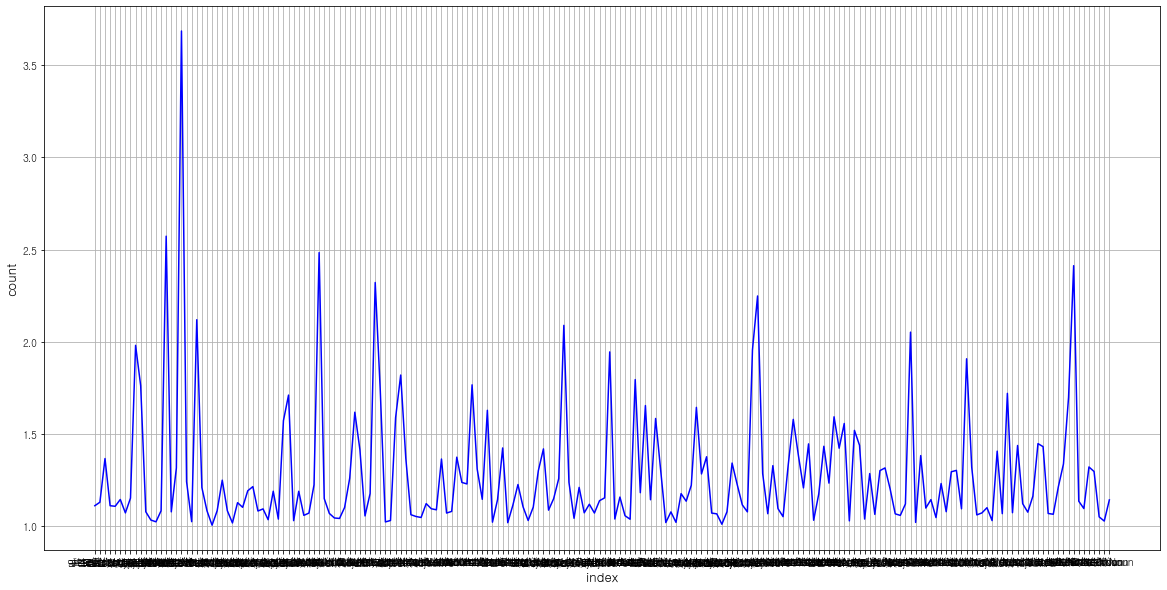

In [18]:
index_list = [i for i in range(200)]
plt.figure(figsize=(20, 10))
plt.plot(selected_word,result_df.mean(),color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("count", fontsize=13)
plt.grid()
plt.show()

<Figure size 1440x720 with 0 Axes>

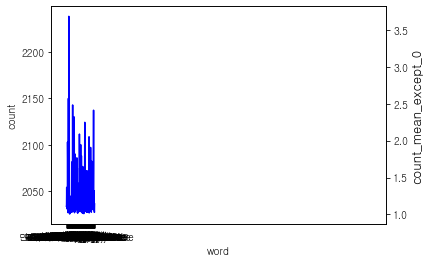

In [20]:
temp = [x for x in tokens_5 if x in rating_5_word_not_common]
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

temp_dist = nltk.Text(temp).vocab().most_common(200)
temp_dist = pd.Series(dict(temp_dist))
plt.figure(figsize=(20, 10))
fig, ax1 = plt.subplots()
ax1.plot(temp_dist[0],temp_dist[1])
ax1.set_xlabel('word')
ax1.set_ylabel('count')
index_list = [i for i in range(200)]
ax2 = ax1.twinx()
plt.figure(figsize=(20, 10))
ax2.plot(selected_word,result_df.mean(),color='b')
ax2.set_ylabel("count_mean_except_0", fontsize=13)
plt.show()

In [154]:
result_mean = result_df.mean()

In [155]:
result_index_mean = result_mean.index.where(result_mean>1.5).tolist()

In [156]:
result_index_mean = [x for x in result_index_mean if not np.isnan(x)]

In [157]:
for i in result_index_mean:
    print(selected_word[int(i)])

단백질/Noun
비타민/Noun
워치/Noun
만두/Noun
유산균/Noun
렌즈/Noun
요거트/Noun
버즈/Noun
디/Noun
수세미/Noun
아몬드/Noun
코멧/Noun
걸이/Noun
이어폰/Noun
틴/Noun
비비고/Noun
퓨저/Noun
시리얼/Noun
뉴트로지나/Noun
모발/Noun
믹스/Noun
눈썹/Noun
록키스/Noun
종아리/Noun
상어/Noun
미국/Noun
클린/Noun
펄프/Noun
스팀/Noun
필/Noun
서울/Noun
요미/Noun


In [158]:
selected_word = rating_1_word_not_common[0:200]
result = []
for d,_,_ in review_token:
    temp = []
    for word in selected_word:
        temp.append(d.count(word))
    result.append(temp)

In [159]:
result_df = pd.DataFrame(result)
result_df = result_df.replace(0,np.NaN)

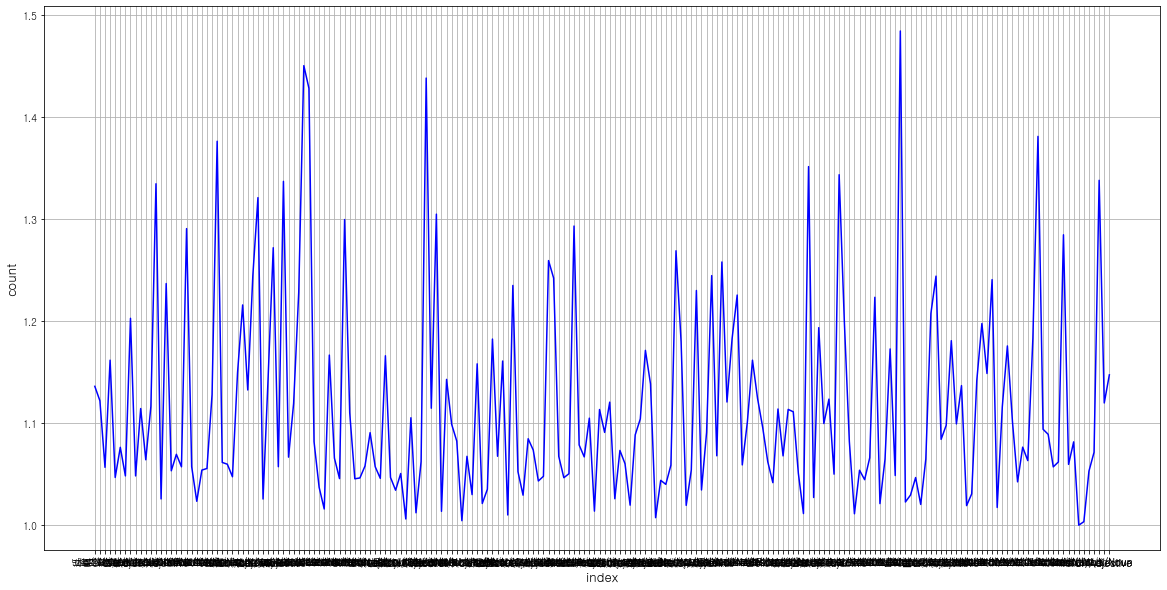

In [160]:
index_list = [i for i in range(200)]
plt.figure(figsize=(20, 10))
plt.plot(selected_word,result_df.mean(),color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("count", fontsize=13)
plt.grid()
plt.show()

In [161]:
result_mean = result_df.mean()
result_index_mean = result_mean.index.where(result_mean>1.2).tolist()
result_index_mean = [x for x in result_index_mean if not np.isnan(x)]
for i in result_index_mean:
    print(selected_word[int(i)])

파손/Noun
문의/Noun
고객/Noun
연락/Noun
펌프/Noun
따갑다/Adjective
토/Noun
전화/Noun
정품/Noun
설사/Noun
보풀/Noun
벌레/Noun
곰팡이/Noun
약품/Noun
대추/Noun
린스/Noun
껍질/Noun
현상/Noun
똥/Noun
소변/Noun
오줌/Noun
증상/Noun
얼음/Noun
털/Noun
날개/Noun
들뜨다/Adjective
발향/Noun
오른쪽/Noun
전원/Noun
저울/Noun
티슈/Noun
시끄럽다/Adjective
매장/Noun
그램/Noun
박카스/Noun
나사/Noun


In [162]:
rating_5_df = df[df['review_rating'] == 5]
rating_1_df = df[df['review_rating'] == 1]

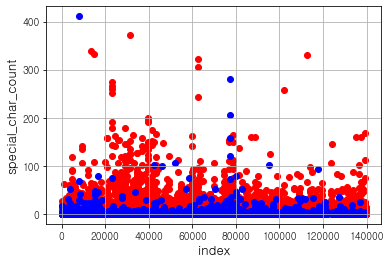

In [163]:
# 5점 리뷰와 1점 리뷰의 특수문자 개수
plt.scatter(rating_5_df.index,rating_5_df['special_char_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['special_char_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("special_char_count", fontsize=13)
plt.grid()
plt.show()

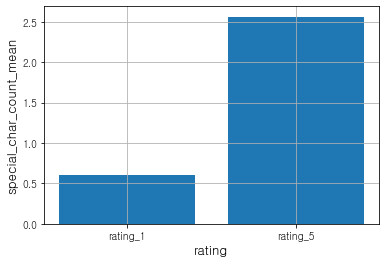

In [164]:
plt.bar(['rating_1','rating_5'],[rating_1_df['special_char_count'].mean(),rating_5_df['special_char_count'].mean()])
plt.xlabel("rating", fontsize=13)
plt.ylabel("special_char_count_mean", fontsize=13)
plt.grid()
plt.show()

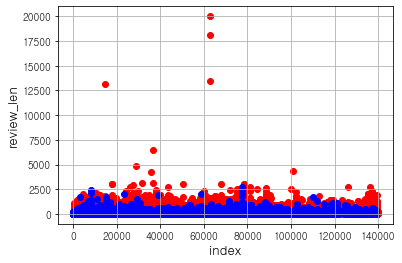

In [165]:
plt.scatter(rating_5_df.index,rating_5_df['review_len'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['review_len'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("review_len", fontsize=13)
plt.grid()
plt.show()

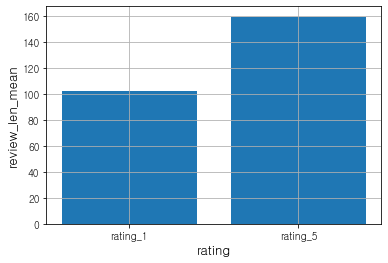

In [166]:
plt.bar(['rating_1','rating_5'],[rating_1_df['review_len'].mean(),rating_5_df['review_len'].mean()])
plt.xlabel("rating", fontsize=13)
plt.ylabel("review_len_mean", fontsize=13)
plt.grid()
plt.show()

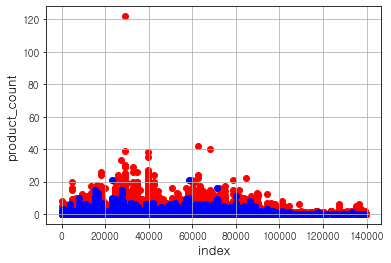

In [167]:
plt.scatter(rating_5_df.index,rating_5_df['product_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['product_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("product_count", fontsize=13)
plt.grid()
plt.show()

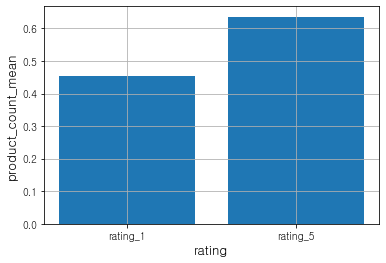

In [168]:
plt.bar(['rating_1','rating_5'],[rating_1_df['product_count'].mean(),rating_5_df['product_count'].mean()])
plt.xlabel("rating", fontsize=13)
plt.ylabel("product_count_mean", fontsize=13)
plt.grid()
plt.show()

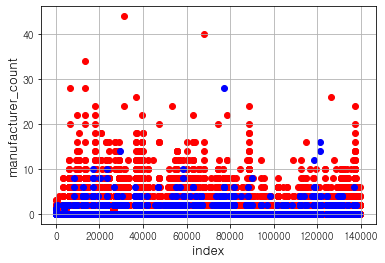

In [169]:
plt.scatter(rating_5_df.index,rating_5_df['manufacturer_count'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['manufacturer_count'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("manufacturer_count", fontsize=13)
plt.grid()
plt.show()

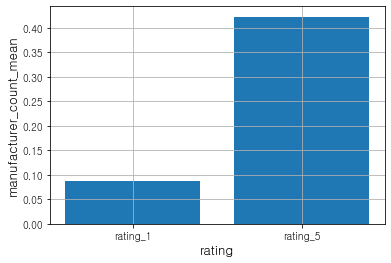

In [170]:
plt.bar(['rating_1','rating_5'],[rating_1_df['manufacturer_count'].mean(),rating_5_df['manufacturer_count'].mean()])
plt.xlabel("rating", fontsize=13)
plt.ylabel("manufacturer_count_mean", fontsize=13)
plt.grid()
plt.show()

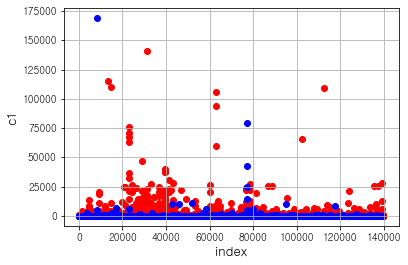

In [171]:
plt.scatter(rating_5_df.index,rating_5_df['c1'],color='r')
plt.scatter(rating_1_df.index,rating_1_df['c1'],color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("c1", fontsize=13)
plt.grid()
plt.show()

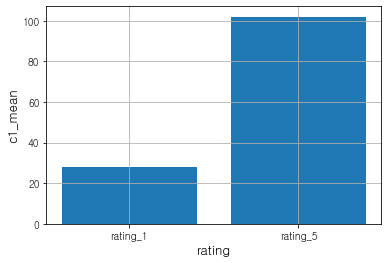

In [172]:
plt.bar(['rating_1','rating_5'],[rating_1_df['c1'].mean(),rating_5_df['c1'].mean()])
plt.xlabel("rating", fontsize=13)
plt.ylabel("c1_mean", fontsize=13)
plt.grid()
plt.show()

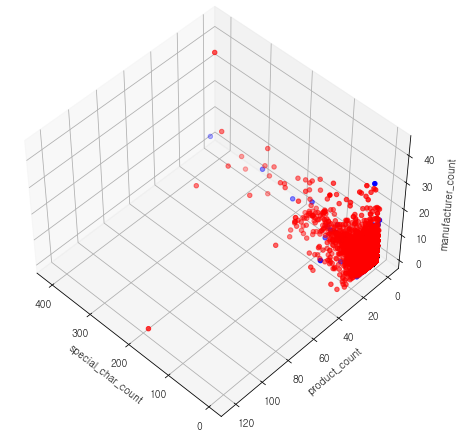

In [253]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(rating_1_df['special_char_count'],rating_1_df['product_count'],rating_1_df['manufacturer_count'], color='blue')
ax.scatter(rating_5_df['special_char_count'],rating_5_df['product_count'],rating_5_df['manufacturer_count'], color='red')
ax.set_xlabel('special_char_count')
ax.set_ylabel('product_count')
ax.set_zlabel('manufacturer_count')
plt.show()

In [174]:
from sklearn.cluster import KMeans 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [175]:
feature = df[['special_char_count','manufacturer_count']]
feature.head()

,special_char_count,manufacturer_count
0,2,1
1,0,0
2,0,1
3,0,0
4,0,0


In [176]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(feature)

KMeans(n_clusters=2)

In [177]:
kmeans_predicted = kmeans.predict(feature)

In [178]:
feature['group'] = kmeans_predicted

<ipython-input-178-034a9109518c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['group'] = kmeans_predicted


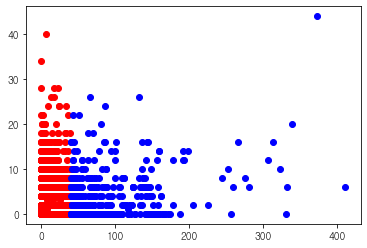

In [179]:
# sns.set(style = "darkgrid")

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection = '3d')

# ax.set_xlabel("special_char_count")
# ax.set_ylabel("product_count")
# ax.set_zlabel("manufacturer_count")

x = feature[feature['group'] == 0]['special_char_count']
# y = feature[feature['group'] == 0]['product_count']
z = feature[feature['group'] == 0]['manufacturer_count']
plt.scatter(x, z,color=['red'])

x = feature[feature['group'] == 1]['special_char_count']
# y = feature[feature['group'] == 1]['product_count']
z = feature[feature['group'] == 1]['manufacturer_count']
plt.scatter(x, z,color=['blue'])

plt.show()

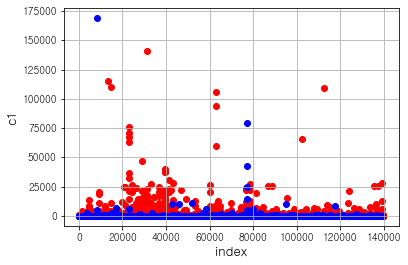

In [180]:
plt.scatter(rating_5_df.index,rating_5_df['special_char_count']**2+rating_5_df['product_count']**2+rating_5_df['manufacturer_count']**2,color='r')
plt.scatter(rating_1_df.index,rating_1_df['special_char_count']**2+rating_1_df['product_count']**2+rating_1_df['manufacturer_count']**2,color='b')
plt.xlabel("index", fontsize=13)
plt.ylabel("c1", fontsize=13)
plt.grid()
plt.show()

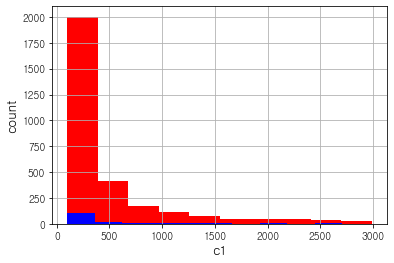

In [181]:
rating_5_hist = rating_5_df[(rating_5_df['special_char_count']**2+rating_5_df['product_count']**2+rating_5_df['manufacturer_count']**2 > 100) & (rating_5_df['special_char_count']**2+rating_5_df['product_count']**2+rating_5_df['manufacturer_count']**2 < 3000)]
plt.hist(rating_5_hist['special_char_count']**2+rating_5_hist['product_count']**2+rating_5_hist['manufacturer_count']**2,color='r')
rating_1_hist = rating_1_df[(rating_1_df['special_char_count']**2+rating_1_df['product_count']**2+rating_1_df['manufacturer_count']**2 > 100) & (rating_1_df['special_char_count']**2+rating_1_df['product_count']**2+rating_1_df['manufacturer_count']**2 < 3000)]
plt.hist(rating_1_hist['special_char_count']**2+rating_1_hist['product_count']**2+rating_1_hist['manufacturer_count']**2,color='b')
plt.xlabel("c1", fontsize=13)
plt.ylabel("count", fontsize=13)
plt.grid()
plt.show()

In [182]:
rating_5_df[rating_5_df['special_char_count']**2+rating_5_df['product_count']**2+rating_5_df['manufacturer_count']**2 == 0]


,product_review_index,product_index,category_index,review_date,review_rating,newline_count,review_len,special_char_count,manufacturer_count,product_count,review_score,c1
246,246,1,1,2021-06-24,5,12,135,0,0,0,None,0.0
254,254,1,1,2021-06-10,5,4,96,0,0,0,None,0.0
257,257,1,1,2020-09-03,5,5,134,0,0,0,None,0.0
261,261,1,1,2021-05-18,5,5,75,0,0,0,None,0.0
272,272,1,1,2021-06-20,5,0,107,0,0,0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
139750,139750,138931,128739,2020-12-02,5,1,112,0,0,0,None,0.0
139751,139751,138931,128739,2021-02-14,5,1,45,0,0,0,None,0.0
139752,139752,138931,128739,2020-12-18,5,2,81,0,0,0,None,0.0
139755,139755,138931,128739,2020-11-19,5,1,109,0,0,0,None,0.0


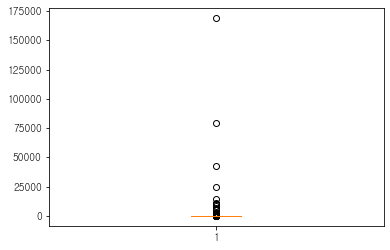

In [261]:
plt.boxplot(rating_1_df[rating_1_df['c1'] > 0]['c1'])
plt.show()

In [232]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    print(upper_bound)
    print(min([x for x in data if x > upper_bound]))

In [255]:
temp = rating_1_df[rating_1_df['c1'] > 0]
outliers_1 = outliers_iqr(temp['c1'])

21.0
22.0


In [204]:
rating_1_df['c1']

0         5.0
1         1.0
2         1.0
3         0.0
4         0.0
         ... 
138984    0.0
138985    0.0
138986    0.0
138987    0.0
138988    1.0
Name: c1, Length: 19556, dtype: float64

In [205]:
rating_1_pms = rating_1_df[rating_1_df['c1']<3000]

In [206]:
(rating_1_pms['c1']).mean()

6.811463664278404

In [239]:
rating_5_pms = rating_5_df[rating_5_df['c1']>=22]

In [240]:
(rating_5_pms['c1']).mean()

622.2675849610478

In [246]:
rating_5_spam = rating_5_df[rating_5_df['c1']>=4]

In [247]:
rating_5_spam

,product_review_index,product_index,category_index,review_date,review_rating,newline_count,review_len,special_char_count,manufacturer_count,product_count,review_score,c1
239,239,1,1,2021-06-27,5,48,866,8,2,8,None,132.0
240,240,1,1,2021-06-07,5,23,726,6,2,5,None,65.0
241,241,1,1,2021-04-28,5,35,1127,26,3,4,None,701.0
242,242,1,1,2021-04-22,5,51,912,19,0,0,None,361.0
243,243,1,1,2021-06-01,5,24,418,8,0,1,None,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...
139744,139744,138931,128739,2020-08-19,5,8,152,0,2,0,None,4.0
139746,139746,138931,128739,2021-01-17,5,3,84,2,0,0,None,4.0
139747,139747,138931,128739,2019-03-20,5,6,201,2,2,0,None,8.0
139753,139753,138931,128739,2021-01-22,5,2,52,2,0,0,None,4.0


In [256]:
rating_spam = df[df['c1']>=22]

In [257]:
# 11959개
# 2651명
rating_spam

,product_review_index,product_index,category_index,review_date,review_rating,newline_count,review_len,special_char_count,manufacturer_count,product_count,review_score,c1
23,23,1,1,2021-06-13,1,3,109,5,0,2,None,29.0
38,38,1,1,2020-06-11,1,2,44,17,0,0,None,289.0
67,67,1,1,2020-06-18,3,5,128,7,0,1,None,50.0
69,69,1,1,2020-09-02,3,13,313,7,0,1,None,50.0
118,118,1,1,2021-06-05,4,7,229,5,0,0,None,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...
139636,139636,138931,128739,2021-03-18,5,0,84,14,0,0,None,196.0
139669,139669,138931,128739,2019-04-24,5,4,184,5,0,0,None,25.0
139680,139680,138931,128739,2020-03-21,5,4,215,5,0,0,None,25.0
139690,139690,138931,128739,2020-06-23,5,0,78,5,0,0,None,25.0


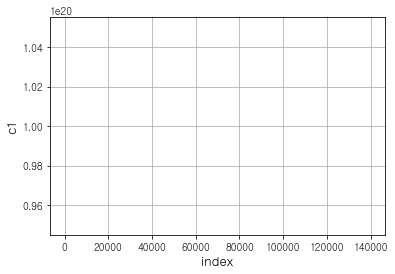

In [ ]:
plt.scatter(rating_5_spam.index,rating_5_spam['review_score'],color='r')
plt.xlabel("index", fontsize=13)
plt.ylabel("c1", fontsize=13)
plt.grid()
plt.show()

In [258]:
conn = pymysql.connect(host='localhost',
                       user='lyunj',
                       password='Dldbswo77@',
                       db='coupang_review',  # coupang_review 스키마 생성 필요
                       charset='utf8',
                       cursorclass=pymysql.cursors.DictCursor)
try:
    with conn.cursor() as curs:
        sql = """select * 
from product_review a 
left outer join review_content b 
on a.product_review_index = b.product_review_index 
and a.product_index = b.product_index
and a.category_index = b.category_index;"""
        curs.execute(sql)
        result = curs.fetchall()
        merge_df = pd.DataFrame(result)
finally:
    conn.close()

In [259]:
rating_spam_merged = pd.merge(left=rating_spam,right=merge_df, how='left', on=['product_review_index','product_index','category_index'])

In [260]:
rating_spam_merged.to_csv('./maybe_spam_22.csv')